**Author**: Konstantin Malykhin

**Date**: 24.10.2020

# Lab 1
## Task
You are working with the datasets:
- NYC boroughs
- subboroughs
- tracts
- population data
- taxi rides

**Your key goal is to find which subboroughs spend the least money per capita on taxi rides on average weekday evening (7-9pm) and average weekday morining (7-9am).**

When solving this task, carefully define what "spend" means in this context and whether you need taxi pickup points, taxi dropoff points or both.

# 1. Pre-processing data

### 1.1. Install neccessary modules

In [1]:
%%capture
pip install pandas numpy geopandas datetime seaborn plotly dash

### NB
After installing the modules, restart the kernel !

### 1.2. Load neccessary modules

In [2]:
## Forcing using shapely >= 2.0.0
import os
os.environ['USE_PYGEOS'] = '0'

## For working with dataframes
import pandas as pd
import json

## For working with space distance
import geopandas as gpd
from geopandas.tools import sjoin

## For working with time
from datetime import datetime

## For working with graphs
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sb

## pandas options
pd.set_option('display.max_columns', None)

### 1.3. Load the data
Before loading the data, put the data folder with required files in the working directory next to the IPython Notebook script !

In [3]:
# NYC population
NYC_pop = pd.read_csv('../data/2010_NYC_Population_by_Census_Tracts.csv')

# Trip data
trips = pd.read_csv('../data/taxi_trips.csv')

# NYC boroughs and subboroughs
NYC_boroughs = gpd.read_file('../data/gisdata/nyc_boroughs.gpkg')
census = gpd.read_file('../data/gisdata/nyc_census_tracts.gpkg')

# Show dataframes and basic infromation
display(NYC_pop.head())
print('Table: NYC_pop' + '\tShape: ' + str(NYC_pop.shape))
display(trips.head())
print('Table: trips' + '\tShape: ' + str(trips.shape))
display(NYC_boroughs.head())
print('Table: NYC_boroughs' + '\tShape: ' + str(NYC_boroughs.shape))
display(census.head())
print('Table: census' + '\tShape: ' + str(census.shape))

Borough  Year  FIPS County Code  DCP Borough Code  Census Tract  Population
0   Bronx  2010                 5                 2           100       11091
1   Bronx  2010                 5                 2           200        4334
2   Bronx  2010                 5                 2           400        5503
3   Bronx  2010                 5                 2          1600        5643
4   Bronx  2010                 5                 2          1900        1917

Table: NYC_pop	Shape: (2168, 6)


VendorID  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2016-03-25T10:13:14Z  2016-03-25T10:27:05Z                5   
1         2  2016-03-25T10:13:14Z  2016-03-25T10:24:35Z                1   
2         2  2016-03-25T10:13:14Z  2016-03-25T10:50:46Z                2   
3         1  2016-03-25T10:13:15Z  2016-03-25T10:21:22Z                1   
4         1  2016-03-25T10:13:15Z  2016-03-25T10:43:53Z                2   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           1.92        -73.983742        40.780811           1   
1           1.68        -73.995758        40.764381           1   
2           8.74        -73.948990        40.788612           1   
3           1.60        -73.974365        40.742847           1   
4          10.70        -73.873055        40.774200           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.958603         40.778423             2   
1                  N         -73.994377         40.750801             2   
2                  N         -74.016373         40.705788             1   
3                  N         -73.970589         40.761047             2   
4                  N         -73.982513         40.742699             1   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         11.0    0.0      0.5        0.00          0.00   
1          9.0    0.0      0.5        0.00          0.00   
2         31.0    0.0      0.5        2.00          0.00   
3          8.0    0.0      0.5        0.00          0.00   
4         33.0    0.0      0.5        7.85          5.54   

   improvement_surcharge  total_amount  
0                    0.3         11.80  
1                    0.3          9.80  
2                    0.3         33.80  
3                    0.3          8.80  
4                    0.3         47.19

Table: trips	Shape: (2649074, 19)


bor_subb                  NAME  CODE          SUBBOROUGH  FORHIS06  \
0       501           North Shore   501         North Shore   37.0657   
1       502            Mid-Island   502          Mid-Island   27.9822   
2       503           South Shore   503         South Shore   10.7019   
3       401               Astoria   401             Astoria   52.0961   
4       402  Sunnyside / Woodside   402  Sunnyside/Woodside   62.7242   

   FORHIS07  FORHIS08  FORHIS09  FORWH06  FORWH07  FORWH08  FORWH09  \
0   34.0317   27.3767   29.3091  13.2540  11.8768  11.1788  11.1459   
1   18.1193   24.0452   31.1566  20.0616  19.8575  22.4870  17.0371   
2   12.1404    9.6890   14.6638  10.3060  12.7699   9.3561  10.2830   
3   53.9585   54.6968   47.8050  38.3658  35.6551  32.1289  34.6578   
4   69.3969   67.0897   58.2963  37.0512  31.9057  32.3264  33.8794   

   HHSIZ1990  HHSIZ00  HHSIZ02  HHSIZ05  HHSIZ08  KIDS2000  KIDS2005  \
0     2.7146   2.7338   2.7412   2.8010   2.6983   39.2995   43.3788   
1     2.8233   2.7176   2.5405   2.6228   2.5749   36.2234   35.7630   
2     3.0547   2.8497   2.6525   2.6121   2.6483   39.7362   42.5232   
3     2.4279   2.4995   2.3032   2.3227   2.2746   28.4592   27.2223   
4     2.4646   2.6287   2.5300   2.4993   2.4766   29.8808   28.6841   

   KIDS2006  KIDS2007  KIDS2008  KIDS2009  RENT2002  RENT2005  RENT2008  \
0   38.4022   41.5213   39.8390   40.3169       800       900      1000   
1   36.9081   37.6798   37.2447   37.8176       650       800       950   
2   40.3577   40.3797   40.4820   35.3880       750       775       800   
3   25.2556   24.8911   22.0364   17.9996      1000      1100      1400   
4   28.1440   26.3675   29.9032   26.2156      1000      1000      1400   

   RENTPCT02  RENTPCT05  RENTPCT08   PUBAST90  PUBAST00    YRHOM02    YRHOM05  \
0    21.1119    24.8073    28.5344  47.329128  6.005791  10.805068  12.127853   
1    32.3615    27.2584    27.9567  35.182323  2.287034  15.241246  15.183111   
2    23.0547    20.4146    18.1590  23.894043  1.350208  12.704250  12.972280   
3    25.6022    26.7685    28.0467  80.533928  5.204510  12.839167  13.377513   
4    18.8079    22.6752    21.3009  75.516866  2.974139  15.387656  12.518789   

     YRHOM08                                           geometry  
0  11.547433  POLYGON ((-74.07838 40.64860, -74.07688 40.648...  
1  14.682124  MULTIPOLYGON (((-74.20153 40.61449, -74.19995 ...  
2  13.561487  MULTIPOLYGON (((-74.18659 40.57708, -74.18370 ...  
3  12.544640  MULTIPOLYGON (((-73.90386 40.78713, -73.90384 ...  
4  12.666909  POLYGON ((-73.90111 40.76029, -73.90081 40.759...

Table: NYC_boroughs	Shape: (55, 35)


CTLabel BoroCode       BoroName  CT2010 BoroCT2010 CDEligibil NTACode  \
0       9        5  Staten Island  000900    5000900          I    SI22   
1      98        1      Manhattan  009800    1009800          I    MN19   
2     100        1      Manhattan  010000    1010000          I    MN19   
3     102        1      Manhattan  010200    1010200          I    MN17   
4     104        1      Manhattan  010400    1010400          I    MN17   

                                     NTAName  PUMA   Shape_Leng    Shape_Area  \
0  West New Brighton-New Brighton-St. George  3903  7729.016666  2.497010e+06   
1                    Turtle Bay-East Midtown  3808  5534.199988  1.906016e+06   
2                    Turtle Bay-East Midtown  3808  5692.168417  1.860938e+06   
3                      Midtown-Midtown South  3807  5687.802440  1.860993e+06   
4                      Midtown-Midtown South  3807  5693.035870  1.864600e+06   

                                            geometry  
0  MULTIPOLYGON (((961685.052 172726.408, 961742....  
1  MULTIPOLYGON (((993521.297 213744.264, 993499....  
2  MULTIPOLYGON (((992351.125 214645.421, 992224....  
3  MULTIPOLYGON (((991458.151 215138.776, 991331....  
4  MULTIPOLYGON (((990566.378 215633.355, 990440....

Table: census	Shape: (2168, 12)


### 1.4. Format the data

In [4]:
%%time
# Transform to geopandas & change projection to 32618 (NYC)
trips = gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips['pickup_longitude'],
                                                            trips['pickup_latitude'])).\
                                                            set_crs(4326).to_crs(32618)
census = census.to_crs(32618)
NYC_boroughs = NYC_boroughs.to_crs(32618)

# Format date and time to python's datetime format
trips['tpep_pickup_datetime'] = pd.to_datetime(trips['tpep_pickup_datetime']).dt.tz_localize(None)
trips['tpep_dropoff_datetime'] = pd.to_datetime(trips['tpep_dropoff_datetime']).dt.tz_localize(None)

CPU times: user 5.19 s, sys: 1.26 s, total: 6.44 s
Wall time: 6.44 s


Since the goal of the task is to count spendings in particular time, let's filter the data - take only weekdays 7-9 am and 7-9 pm.

In [5]:
# Get only neccessary weekdays and time of day

# Get workdays
trips = trips[~trips['tpep_pickup_datetime'].dt.day_name().isin(['Saturday', 'Sunday'])]

## Get 7-9 AM and 7-9 PM
trips = trips[((trips['tpep_pickup_datetime'].dt.time > datetime.strptime('19:00:00', '%H:%M:%S').time()) &
               (trips['tpep_pickup_datetime'].dt.time < datetime.strptime('21:00:00', '%H:%M:%S').time()) | 
               (trips['tpep_pickup_datetime'].dt.time > datetime.strptime('07:00:00', '%H:%M:%S').time()) &
               (trips['tpep_pickup_datetime'].dt.time < datetime.strptime('09:00:00', '%H:%M:%S').time()))].\
        reset_index(drop=True)

It seems like the data is ready for the analysis.

# 2. Analysis

### NB
For the analysis of spendings, it's neccessary to define 'spendings'. In this case, spendings - total amount of money that is spent for taxi trip at the pickup location.

In [6]:
# Create column with 'spendings' per passenger
trips['amount_per_passenger'] = (trips['total_amount'] / trips['passenger_count']).round(2)

Now let's merge data with population to the census dataframe.

In [7]:
# CT2010 to int for mergening
census['CT2010'] = census['CT2010'].astype(int)

In [8]:
# Merge population to census
census_table = census.merge(NYC_pop,
                      left_on=['BoroName', 'CT2010'], right_on=['Borough', 'Census Tract'],
                      how='left')[['BoroName', 'CT2010', 'NTAName', 'Census Tract', 'Population', 'geometry']]

# Get only centroids of geometry to avoid double counting
census_table['geometry'] = census_table.centroid

Now we have the dataframe of the census tracts with population. Let's merge census tracts and its population to the subboroughs by spatial join.

In [9]:
%%time
# Spatial join of census data and subboroughs
NYC_boroughs = sjoin(NYC_boroughs[['NAME', 'geometry']],
                     census_table, how='left', predicate='intersects').\
              groupby(['NAME'])[['Population']].sum().reset_index().\
              merge(NYC_boroughs[['NAME', 'geometry']], on='NAME', how='left')

# From pandas to geopandas
NYC_boroughs = gpd.GeoDataFrame(NYC_boroughs, geometry=NYC_boroughs['geometry']).set_crs(32618)

CPU times: user 26 ms, sys: 1.03 ms, total: 27 ms
Wall time: 25.4 ms


In [10]:
# Get the difference of the population after spatial join
census_table['Population'].sum() - NYC_boroughs['Population'].sum()

301164

## NB
Here we got difference 301164 people that were 'lost' after spatial join. Here is the closest method to 'save' as many people as possible and at the same time avoid double counting.

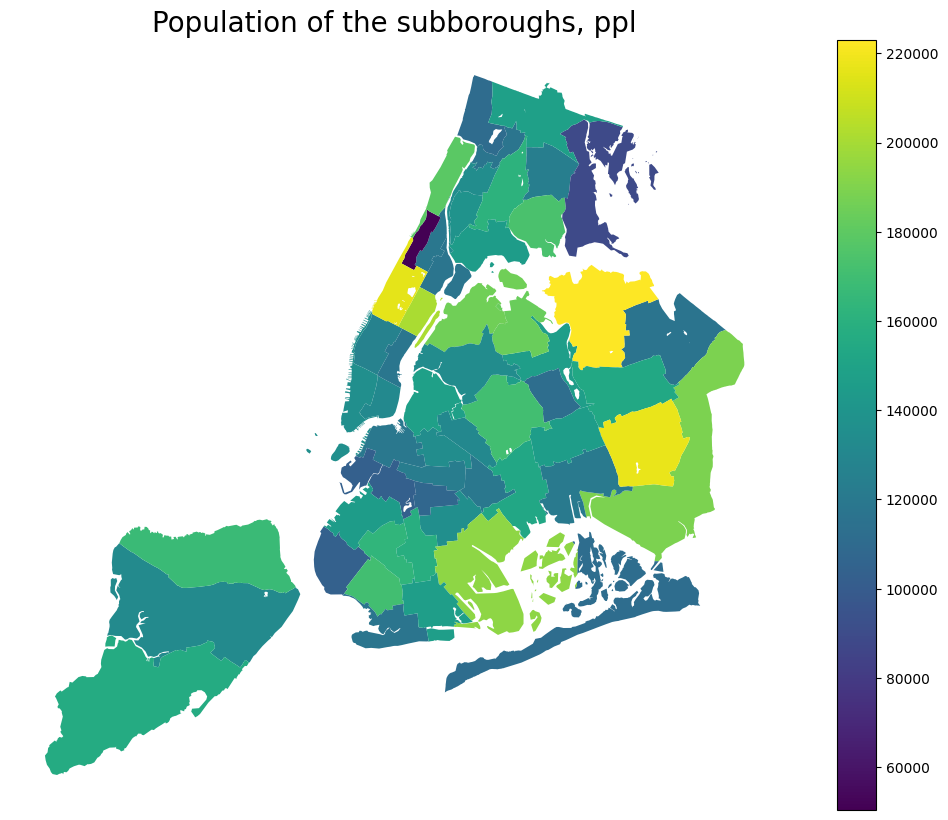

In [11]:
# Plot the subborughs with population
f, ax = plt.subplots(1, figsize=(15, 10))
NYC_boroughs.plot(ax=ax, column='Population', legend=True)
ax.set_axis_off()
ax.set_title('Population of the subboroughs, ppl', size = 20)
# plt.axis('equal')
plt.show()

Now let's count total spending per capita in each subboroughs.

In [12]:
%%time
# Spatial join of trips and subboroughs
NYC_boroughs = sjoin(NYC_boroughs, trips[['geometry', 'total_amount']], how='left').\
                     reset_index(drop=True).drop(columns=['index_right'])

# Merge population and geometries
NYC_boroughs = NYC_boroughs.groupby('NAME')[['total_amount']].sum().reset_index().\
                            merge(NYC_boroughs[['NAME', 'geometry', 'Population']].drop_duplicates('NAME'),
                                  on='NAME', how='left').round(2)

# To geopandas
NYC_boroughs = gpd.GeoDataFrame(NYC_boroughs, geometry=NYC_boroughs['geometry']).set_crs(32618)

# 
NYC_boroughs['amount_per_capita'] = (NYC_boroughs['total_amount'] / NYC_boroughs['Population'])

CPU times: user 1 s, sys: 7.6 ms, total: 1.01 s
Wall time: 1.01 s


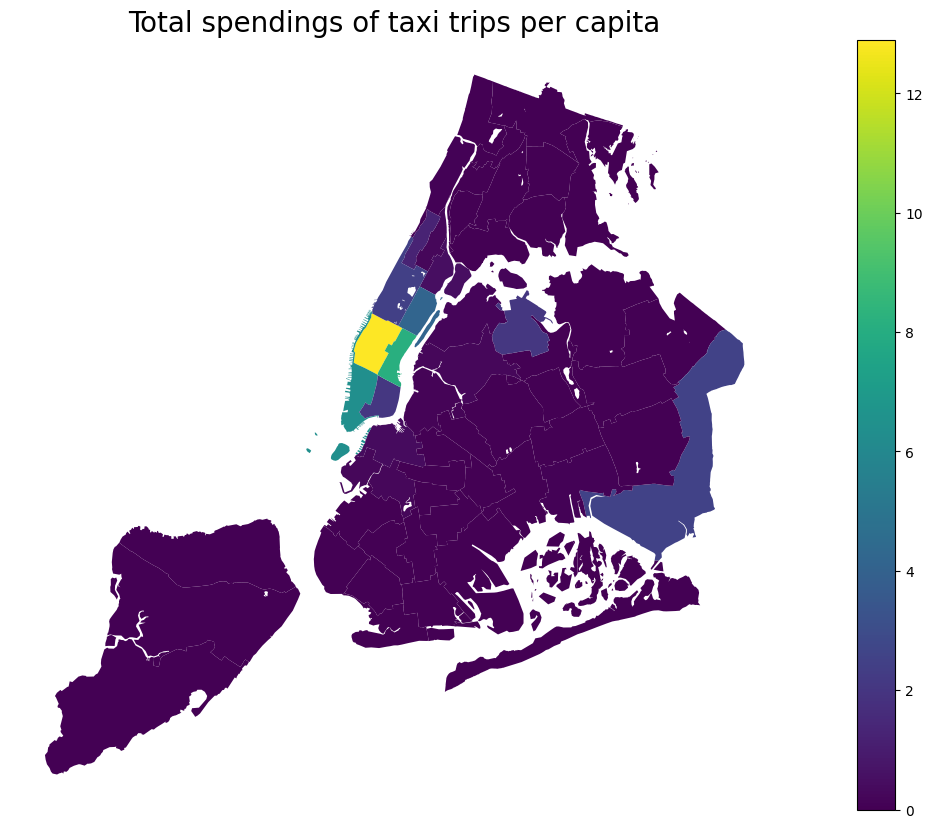

In [13]:
# Plot the subboroughs with total amount of taxi trips per capita
f, ax = plt.subplots(1, figsize=(20, 10))
NYC_boroughs.plot(ax=ax, column='amount_per_capita', legend=True)
ax.set_axis_off()
ax.set_title('Total spendings of taxi trips per capita', size = 20)
# plt.axis('equal')
plt.show()

In [14]:
# Show the subboroughs with minimum taxi trips spendings per capita
display(NYC_boroughs.sort_values('amount_per_capita').head(6)[['NAME', 'Population',
                                                               'total_amount', 'amount_per_capita']].\
                                                              reset_index(drop=True))

# Show the barchart
fig = px.bar(NYC_boroughs.sort_values('amount_per_capita').head(6), y='amount_per_capita',
             x='NAME', text='amount_per_capita')
# Update layout
fig.update_layout(
    title='Subboroughs with minimum taxi trips spendigs per capita',
    xaxis_title='Subborough',
    yaxis_title='Amount per capita')
# Update text
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
# Show the figure
fig.show()

NAME  Population  total_amount  amount_per_capita
0                  South Shore      155693          0.00           0.000000
1        Bayside / Little Neck      116852         28.10           0.000240
2               Pelham Parkway      123764         35.60           0.000288
3                  Bensonhurst      170985         68.06           0.000398
4  Williamsbridge / Baychester      148040         73.62           0.000497
5                 Coney Island      117274         68.40           0.000583

P.s. **South Shore** is included in subboroughs despite there is no any data for taxi rides during the filtered time.

In [15]:
# Make a map
fig = px.choropleth_mapbox(NYC_boroughs,
                           geojson=NYC_boroughs.to_crs(4326).geometry,
                           locations=NYC_boroughs.index,
                           color='amount_per_capita',
                           hover_name='NAME',
                           center={'lat': 40.71, 'lon': -74.00},
                           mapbox_style='carto-positron',
                           opacity=0.5,
                           labels={'amount_per_capita':'amount_per_capita'},
                           zoom=9)
# Get rid of margin
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0},
                  title='Spendings on taxi trips on weekdays at 7-9 am and at 7-9 pm per capita')
# Show the figure
fig.show()

Thus, after the analysis, it could be seen that in subboroughs such as **Bayside / Little Neck**, **Pelham Parkway**, **Bensonhurst**, **Williamsbridge / Baychester** and **Coney Island**, taxi rides spendings on average weekday at 7-9 am and 7-9 pm are minimum among all the subboroughs.